## Board Games - Recommender System

**The goal here is to make a supervised personalized recommendation system using collaborative filtering**

- **Recommendation Systems** (also known as recommendation engines) are a relatively new prediction method that uses algorithms such as **Collaborative filtering** (CF) and Clustering that try to provide an insight not seen before by the user. In our case we initially try to implement a CF using a dataset with over 15 million rows. These reviews were scraped from https://boardgamegeek.com/.

- **Offering some context to board games**, the definition is pretty open, but you basically need a mechanic to use during the game and some sort of definition of who and how someone can win in that game. We can find games that uses pieces, boards, cards, dice, coins, resources and nowadays we even have eletronics involved in board games.

> **Our data counts with 3 different datasets:**
>- **bgg_reviews**: Board Game Geek reviews with over 15 million reviews
>- **games_info**: Information for the board game, with some other information like number of players and designer
>- **reviews_summary**: A summary of the boardgame, how it is ranked on the website, and its average rating and how many users voted

For our first recommender, since we are not planning for now to do NLP or use more in depth information like "designer of the game" for further analysis we are only going to use the first data set.

In [1]:
import random
import pandas as pd
import seaborn as sns
from surprise import accuracy
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD
from surprise.prediction_algorithms import knns
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.similarities import cosine, msd, pearson
import warnings; warnings.simplefilter('ignore')

In [2]:
bgg_reviews = pd.read_csv('../../../bgg-15m-reviews.csv')

### Bring useful functions to the data exploration

In [3]:
def basic_info(data):
    """ Gets basic information to understand more of the data, also useful to delete columns that we know are categorical"""
    print("Dataset shape is: ", data.shape)
    print("Dataset size is: ", data.size)
    print(data.duplicated().sum())
    print("Dataset columns are: ", data.columns)
    print("Dataset info is: ", data.info())
    categorical = []
    numerical = []
    for i in data.columns:
        if data[i].dtype == object:
            categorical.append(i)
        else:
            numerical.append(i)
    print("Categorical variables are:\n ", categorical)
    print("Numerical variables are:\n ", numerical)
    return categorical, numerical

In [4]:
def columns_w_nan(data, y):
    """ Returns the columns that have over y% of its data as missing value """
    temp = []
    temp_perce = []
    for x in data.columns:
        if data[x].isna().sum() > 0:
            percentage_of_data = data[x].isna().sum()/(list(data.shape)[0])
            print("Row: {} : is made {}% of NaN Values.".format(x, percentage_of_data.round(3)))
            if percentage_of_data > y:
                temp.append(x)
                temp_perce.append(percentage_of_data)
    if len(temp) > 0:
        print('')            
        print(temp)
        print('')
        print(temp_perce)

In [5]:
basic_info(bgg_reviews)

Dataset shape is:  (15823269, 6)
Dataset size is:  94939614
0
Dataset columns are:  Index(['Unnamed: 0', 'user', 'rating', 'comment', 'ID', 'name'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15823269 entries, 0 to 15823268
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   user        object 
 2   rating      float64
 3   comment     object 
 4   ID          int64  
 5   name        object 
dtypes: float64(1), int64(2), object(3)
memory usage: 724.3+ MB
Dataset info is:  None
Categorical variables are:
  ['user', 'comment', 'name']
Numerical variables are:
  ['Unnamed: 0', 'rating', 'ID']


(['user', 'comment', 'name'], ['Unnamed: 0', 'rating', 'ID'])

In [6]:
columns_w_nan(bgg_reviews, 0.3)

Row: user : is made 0.0% of NaN Values.
Row: comment : is made 0.811% of NaN Values.

['comment']

[0.8107203385090653]


In [7]:
# We check what our data looks like (For example we noticed "Unnamed: 0" on our basic_info function)
# and we set random_state for reproducibility
bgg_reviews.sample(3, random_state=22)

,Unnamed: 0,user,rating,comment,ID,name
6036524,6036524,ckessel,7.0,Eh. It's very Euro and it feels much like othe...,9216,Goa
1133390,1133390,mazinho,8.0,NaN,70323,King of Tokyo
12202475,12202475,mstadtner,7.0,"Awesome, if frustrating game. It does a great ...",127518,A Distant Plain


- Since we do not plan to use comments (in reality those are qualitative reviews) for now and they have a lot of missing values (around 80%), we drop them.
- We also drop 'Unnamed: 0' because we notice it is a repeat of the index.
- The other column we are going to drop is the 'name', because it is represented already by ID as you can see here:

![title](../../../../capimages/part_1_install.png)

King of Tokyo = 70323, great game by the way. Coolest dice I have ever seen.

In [8]:
# .drop and inplace=True so we keep our changes
bgg_reviews.drop(columns=['comment', 'Unnamed: 0', 'name'], inplace=True)

In [9]:
# We now drop the remaining NaN values that exist on the 0%, since having user is fundamental for our analysis
bgg_reviews.dropna(inplace=True)

In [10]:
# Sample of our data again to check how our data looks like
bgg_reviews.sample(3, random_state=22)

,user,rating,ID
13907171,DeanMary,8.0,6137
147029,DarrylFerster,10.0,10630
13243091,Scubaroo,8.0,175695


In [11]:
# We use cat.codes to designate each user an unique ID
bgg_reviews['user'] = bgg_reviews['user'].astype('category').cat.codes

In [12]:
# We change the name of the columns to follow more of a pattern and be more descriptive
bgg_reviews.columns = ['user_id', 'rating', 'game_id']

In [13]:
# Now we have to rearrange the columns to a form that the model understand, that is:
cols = ['user_id', 'game_id', 'rating']
bgg_reviews = bgg_reviews[cols]

(array([1.8688e+04, 3.3100e+02, 1.3100e+02, 5.9000e+01, 3.5000e+01,
        3.3000e+01, 1.1000e+01, 1.3000e+01, 5.0000e+00, 6.0000e+00,
        1.0000e+00, 7.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([3.00000e+01, 4.84020e+03, 9.65040e+03, 1.44606e+04, 1.92708e+04,
        2.40810e+04, 2.88912e+04, 3.37014e+04, 3.85116e+04, 4.33218e+04,
        4.81320e+04, 5.29422e+04, 5.77524e+04, 6.25626e+04, 6.73728e+04,
        7.21830e+04, 7.69932e+04, 8.18034e+04, 8.66136e+04, 9.14238e+04,
        9.62340e+04]),
 <BarContainer object of 20 artists>)

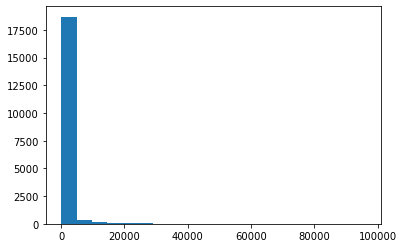

In [14]:
# Game
plt.hist(bgg_reviews['game_id'].value_counts(), bins=20)

In [62]:
bgg_reviews['game_id'].value_counts()[0:5]

30549    96234
822      96220
13       96184
68448    79870
36218    74953
Name: game_id, dtype: int64

**Here we have our data ready to feed to whatever model we decide to use, but to make it lighter on the modeling we decide to use only a fraction of the whole data for now**:

The data is sorted by game, which we should pay attention to the way we will get the data so we keep a "healthy" ratio of number of users and items

In [17]:
"The number of board games is: {}, and {} of users".format(len(bgg_reviews['game_id'].unique()),
                                                           len(bgg_reviews['user_id'].unique()))

'The number of board games is: 19330, and 351048 of users'

The porportion is around 18 users for every 1 board game, so it is an item-item similarity situation.
Let's try to keep the same proportion.

In [18]:
bgg_reviews_subset = bgg_reviews.sample(1000000, random_state=22)

In [19]:
"The number of board games is: {}, and {} of users".format(len(bgg_reviews_subset['game_id'].unique()),
                                                           len(bgg_reviews_subset['user_id'].unique()))

'The number of board games is: 18893, and 189600 of users'

**That's a worse proportion - around 10 instead of 18, but let's move on.**

In [53]:
bgg_reviews_subset.head()

,user_id,game_id,rating
13907171,38098,6137,8.0
147029,36743,10630,10.0
13243091,139805,175695,8.0
15117025,73348,7097,6.0
15114494,319493,10915,7.0


In [54]:
bgg_reviews_subset['rating'].mean()

7.0547770227800015

In [56]:
bgg_reviews_subset[bgg_reviews_subset['game_id'] == 70323].mean()

user_id    177504.361844
game_id     70323.000000
rating          7.210681
dtype: float64

## For our modeling we try different approaches to find the best one:
**(Spoiler alert: it is going to be the last one)**

We need to instatiate Reader to transform our dataset into a form that the library (Surprise) can read.

In [20]:
# We need to specify the range for the rating scale, since the default is 1 to 5
reader = Reader(rating_scale=(1,10))

- Neighborhood-Based

In [21]:
# We transform the dataset into a surprise-dataset
data = Dataset.load_from_df(bgg_reviews_subset, reader)

In [22]:
# We run train-test split on the data so we can validate it later
trainset, testset = train_test_split(data, test_size=0.25, random_state=22)

In [23]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  171595 

Number of items:  18440 



**We first try cosine similarity**

In [24]:
# Here we define that we want cosine similarity approach and set the user_based to false, since we have more users than items
sim_cos = {'name':'cosine', 'user_based':False}

In [25]:
# We set the model (KNN) and use the sim_cos defined before
basic = knns.KNNBasic(sim_options=sim_cos)
# We fit the model
basic.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [26]:
# We get the predictions of our first model
predictions = basic.test(testset)

In [27]:
# And this is what it looks like one prediction
predictions[0]

Prediction(uid=241779, iid=4991, r_ui=7.0, est=9.0, details={'actual_k': 1, 'was_impossible': False})

In [28]:
# The accuracy that we are going to use is RMSE(root-mean-square error), but you can also use
# MAE(Mean Absolute Error) and FCP(Fraction of Concordant Pairs).
print(accuracy.rmse(predictions))

RMSE: 1.6322
1.6321928161994432


**Now we try pearson correlation**

In [29]:
sim_pearson = {'name':'pearson', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [30]:
print(accuracy.rmse(predictions))

RMSE: 1.6814
1.6813701984732634


It seems that cosine similarity is better for our situation, but lets try pearson with knn with means instead of the vanilla version:

In [31]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(trainset)
predictions = knn_means.test(testset)


Computing the pearson similarity matrix...
Done computing similarity matrix.


In [32]:
print(accuracy.rmse(predictions))

RMSE: 1.5124
1.512350332149912


And now Pearson with Baseline:

In [33]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [34]:
print(accuracy.rmse(predictions))

RMSE: 1.4672
1.4671510425952061


### We can also try Model-Based methods instead of Memory-Based

SVD is the most well-known algorithm

In [37]:
svd = SVD(n_factors=100, n_epochs=10, lr_all=0.005, reg_all=0.4, verbose=False)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.3744
1.374389443248155


In [68]:
bgg_reviews_subset.head()

,user_id,game_id,rating
13907171,38098,6137,8.0
147029,36743,10630,10.0
13243091,139805,175695,8.0
15117025,73348,7097,6.0
15114494,319493,10915,7.0


In [41]:
svd.predict(73348, 1)

Prediction(uid=73348, iid=1, r_ui=None, est=7.434814806894602, details={'was_impossible': False})

In [69]:
svd.predict(73348, 7097)

Prediction(uid=73348, iid=7097, r_ui=None, est=6.585540235479425, details={'was_impossible': False})

In [42]:
svd.predict(139805, 1)

Prediction(uid=139805, iid=1, r_ui=None, est=7.910528243084789, details={'was_impossible': False})

In [70]:
svd.predict(139805, 175695)

Prediction(uid=139805, iid=175695, r_ui=None, est=7.636191823182853, details={'was_impossible': False})

### Unbiased Accuracy Estimation

Here we try a different approach that uses validation and shuffle of the ratings to make the model more leakage-proof and have more of an unbiased estimation.
You can find the documentation here(https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-save-some-data-for-unbiased-accuracy-estimation)

In [44]:
raw_ratings = data.raw_ratings
random.shuffle(raw_ratings)
threshold = int(.8 * len(raw_ratings))

In [45]:
A_raw_ratings = raw_ratings[:threshold]

In [46]:
B_raw_ratings = raw_ratings[threshold:]

In [47]:
data.raw_ratings = A_raw_ratings

In [48]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data)

In [49]:
algo = grid_search.best_estimator['rmse']

In [50]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [51]:
predictions = algo.test(trainset.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictions)

Biased accuracy on A,   RMSE: 1.1181


1.1180518353542077

In [52]:
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions)

Unbiased accuracy on B, RMSE: 1.3590


1.3590320717254945